<a href="https://colab.research.google.com/github/avisinghal6/Decision-Tree/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
from decision_tree_functions import *
from helper_functions import *

In [ ]:
%matplotlib inline
sns.set_style("darkgrid")

In [ ]:
# Section 1: Train Decision Train on Iris Data

df = pd.read_csv("Iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"species": "label"})

In [ ]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
random.seed(0)
train_data, test_data = train_test_split(df, test_size=20)

In [ ]:
data = train_data.values
data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']], dtype=object)

Note: Example Representation of Decision Tree:  
example_tree = {"petal_width <= 0.8": ["Iris-setosa", 
                                      {"petal_width <= 1.65": [{"petal_length <= 4.9": ["Iris-versicolor", 
                                                                                        "Iris-virginica"]}, 
                                                                "Iris-virginica"]}]}

In [ ]:
# Run the Decision Tree classifier on Training data

tree = decision_tree_algorithm(train_data, max_depth=3)
pprint(tree)

{'Sex = male': [{'Fare <= 9.4833': [0, {'Age <= 6.0': [1, 0]}]},
                {'Pclass = 3': [{'Fare <= 24.15': [1, 0]}, 1]}]}


In [ ]:
# Test Accuracy

accuracy = calculate_accuracy(test_data, tree)
print ("Test accuracy for Iris data is: " + str(accuracy))

Test accuracy for Iris data is: 0.95


In [ ]:
# Section 2: Train Decision Tree on Titanic data

df = pd.read_csv("Titanic.csv")
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

df = df.fillna({"Age": median_age, "Embarked": mode_embarked})

In [ ]:
random.seed(0)

train_data, test_data = train_test_split(df, 0.2)
tree = decision_tree_algorithm(train_data, max_depth=10)
accuracy = calculate_accuracy(test_data, tree)

accuracy = calculate_accuracy(test_data, tree)
print ("Test accuracy for Titanic data is: " + str(accuracy))

Test accuracy for Titanic data is: 0.7808988764044944


In [ ]:
# Section 3: Prune Tree

'''
This function split the "data" into two parts according to the "criterion",
where "criterion" consists of feature_name, comparison_operator, and the value for splitting,
and "data" is a dataframe object that contains all the data points at this given node of the tree.
'''
def split_data(data, criterion):
    feature, comparison_operator, value = criterion.split()
    
    # continuous feature
    if comparison_operator == "<=":
        left_data = data[data[feature] <= float(value)]
        right_data = data[data[feature] >  float(value)]
        
    # categorical feature
    else:
        left_data = data[data[feature].astype(str) == value]
        right_data  = data[data[feature].astype(str) != value]
    
    # Return the two partitions of the data after splitting
    return left_data, right_data

In [ ]:
'''
This function returns the majority label value of data (if classification) or mean label value of data (if regression)
'''
def get_majority_or_mean_label(data, ml_task="classification"):
    # If task is regression, return the mean value of all the labels
    if ml_task == "regression":
        return data.label.mean()
    
    # If classification, return the majority class label
    else:
        return data.label.value_counts().index[0]

In [ ]:
'''
This function takes data and a tree object (string if the tree is leaf, or dict object if it is not leaf),
makes prediction on the data using the given tree and calculates the error
Input:
    node: a dataframe object that include all the data points in that given node of the tree
    tree: a string/float value (if the tree is a leaf) or a dictionary object(if it is not a leaf) built recursively 
         in the following format {criterion : [left_subTree, right_subTree]}, where left_subTree and 
         right_subTree can be either a string/float (if it is leaf) or a dictionary (if it is not a leaf).
         To see an example of what the tree object looks like, take a look at the output of one of the cells above. 
'''
def calculate_error(data, tree, ml_task="classification"):
    prediction_labels = make_predictions(data, tree)
    actual_labels = data.label
    
    if ml_task == "regression":
        # mean squared error
        return ((prediction_labels - actual_labels) **2).mean()
    else:
        # number of errors
        return sum(prediction_labels != actual_labels)

In [ ]:
'''
This is a helper function that may be invoked in the prune_algorithm() to decide whether to prune the tree or not.
This function takes a tree object, training_data, validation_data as the input.
The intuition behind this function is that it checks whether predicting with the given tree produces a better outcome than simply 
getting the majority/mean label from the training data. The way we check this is to use a validation dataset. We first 
compute the error of making prediction on the validation data using just the majority/mean label of the training data. 
We then compute the error of making prediction on the validation data using the tree. If the former is better 
than the latter, we discard the tree and simply return the majority class label (i.e. we prune the tree). Otherwise, 
we keep the original tree and return it.
'''
def prune_tree_helper(tree, data_train, data_val, ml_task="classification"):
    
    majority_label = get_majority_or_mean_label(data_train, ml_task)
    errors_using_majority_label = calculate_error(data_val, majority_label, ml_task)
    
    errors_using_tree = calculate_error(data_val, tree, ml_task)

    if errors_using_majority_label <= errors_using_tree:
        return majority_label
    else:
        return tree

In [ ]:
'''
TODO: Complete the implementation of this function

This function takes a given tree, training data, and validation data, and prune the tree based on the 
prediction performance on the validation data at each node of the tree. This function will be implemented
recursively.

Input: 
    cur_tree: a dict object (if the tree is not a leaf), or a string/float value (if the tree is a leaf)
    data_train: a dataframe object represents the training data at this given node of the tree
    data_val: a dataframe object represents the validation data at this given node of the tree
    ml_task: a string that is either "regression" or "classification"
Return:
    a tree that is pruned (a string/float value if the tree is a single leaf, or a dict object if
    the tree has branches)
'''

def prune_algorithm(cur_tree, data_train, data_val, ml_task="classification"):
    
    if not isinstance(cur_tree, dict):
        ################################################################
        # Base case: if tree is a single leaf, just return the tree
        # TODO: ~1 line of code expected
        #
        ################################################################
        return cur_tree
        
        
        
    else:    
        criterion = list(cur_tree.keys())[0]
        left_tree, right_tree = cur_tree[criterion]
        data_train_left,data_train_right=split_data(data_train,criterion)
        data_val_left,data_val_right=split_data(data_val,criterion)
        pruned_left_tree=prune_algorithm(left_tree,data_train_left,data_val_left,ml_task)
        pruned_right_tree=prune_algorithm(right_tree,data_train_right,data_val_right,ml_task)
        cur_tree = {criterion: [pruned_left_tree, pruned_right_tree]}
        pruned_tree=prune_tree_helper(cur_tree,data_train,data_val,ml_task)
        return pruned_tree

        ################################################################
        # Recursive case: if tree has branches, do the following steps
        # 1. split data_train into two parts "data_train_left" and "data_train_right" based on the "criterion" 
        #    (hint: use split_data method)
        # 2. split data_val into two parts "data_val_left" and "data_val_right" based on the "criterion" 
        #    (hint: use split_data method)
        # 3. recursively call prune_algorithm on left_tree, data_train_left, data_val_left to get the pruned left tree
        # 4. recursively call prune_algorithm on right_tree, data_train_right, data_val_right to get the pruned right tree
        # 5. Update the cur_tree as cur_tree = {criterion: [pruned_left_tree, pruned_right_tree]}
        # 6. Prune the cur_tree that is updated in step 5 and return the pruned tree (if the tree doesn't need to be 
        #    pruned, just return cur_tree.(hint: you may use prune_tree_helper to decide whether to prune a tree or not)
        # TODO: ~6 line of code expected
        #
        ################################################################
        
        
        


In [ ]:
prune_algorithm(tree,train_data,test_data)

{'Sex = male': [{'Fare <= 9.4833': [0,
    {'Age <= 6.0': [{'Pclass = 3': [0, 1]},
      {'Pclass = 1': [{'Age <= 52.0': [{'Fare <= 30.5': [{'Fare <= 26.0': [0,
              {'Fare <= 29.7': [{'Fare <= 26.55': [1, 0]}, 1]}]},
            0]},
          0]},
        0]}]}]},
  {'Pclass = 3': [{'Fare <= 24.15': [{'Age <= 36.0': [{'Embarked = S': [{'Age <= 31.0': [{'Fare <= 16.7': [{'Fare <= 10.5167': [0,
                1]},
              0]},
            1]},
          1]},
        0]},
      0]},
    1]}]}

In [ ]:
'''
After you implemented prune_algorithm function, run the following cells to compare the test
accuracy of pre-pruned tree and post-pruned tree on TiTanic Dataset. You will get a plot that 
compares the two. No modification of code is needed.
'''

# Load Titanic Data

df = pd.read_csv("Titanic.csv")
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

df = df.fillna({"Age": median_age, "Embarked": mode_embarked})

In [ ]:
# Compare test accuracy of Decision Tree before and after pruning
random.seed(1)
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}
for n in range(10, 26):
    df_train, df_test = train_test_split(df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    tree_pruned = prune_algorithm(tree, df_train, df_val, ml_task="classification")
    
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
    
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")

<AxesSubplot:xlabel='max_depth'>

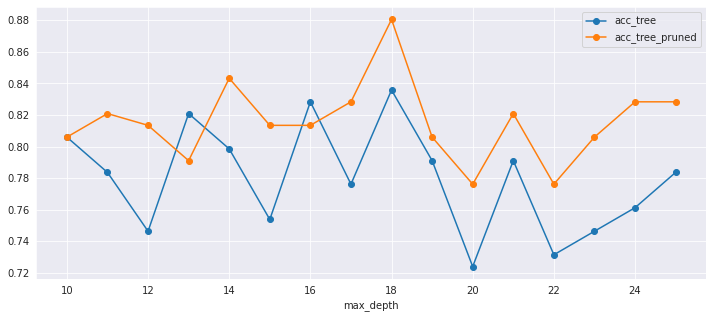

In [ ]:
# Plot
df_metrics.plot(figsize=(12, 5), marker="o")

The accuracy of the model has increased for almost all depths after pruning which indicates that there were some extra levels in the decision tree which were adding more losses and it was a better option to prune the tree at those points and make it a leaf node. This is evident because the pruning strategy at every node is that if the accuracy by predicting the maximum frequency label according to the training data for that node is higher than the accuracy computed by using the entire tree, then it is a better option to prune the tree and just use the max frequency label as the leaf node.

At depth 10, the pruned and the unpruned model give same performance which indicates that there are no extra levels in the tree. However, when the levels are increased, there are only two values of depths at which the accuracy of the pruned model is worse, these depths are 13,16. Apart from these two values, the accuracy of pruned model is always better. After depth 16, the pruned model is consistently better. I think that after a certain depth it is not very helpful to further increase the depth of the decision tree, I think by increasing the depth we might be overfitting on the training data, hence the model performs poorly on the validation. Increasing the depth further will lead to increased computation costs without benefit on accuracy. The accuracy for both models is highest at depth 18, also after depth 18, there seems to be a correlation between the outputs of the pruned and unpruned model i.e both are increasing/decreasing together, but before depth 18, it is not the case. The pruning criteria ensures that we are not taking a hit on the accuracy due to pruning.

I think before 10 depths, the pruned model should mostly perform worse as I believe there should be a threshold number of depths which are needed for the model to perform well, and only after that pruning should make sense. To check my hypothesis, i ran the below experiment by varying depths from 1-26, the results in the 1-9 section indicate that mostly the unpruned model is better even though the pruned model gives higher accuracy sometimes, but the unpruned model gives better accuracy more number of times.

In [ ]:
# Compare test accuracy of Decision Tree before and after pruning
random.seed(1)
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}
for n in range(1, 26):
    df_train, df_test = train_test_split(df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    tree_pruned = prune_algorithm(tree, df_train, df_val, ml_task="classification")
    
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
    
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")

<AxesSubplot:xlabel='max_depth'>

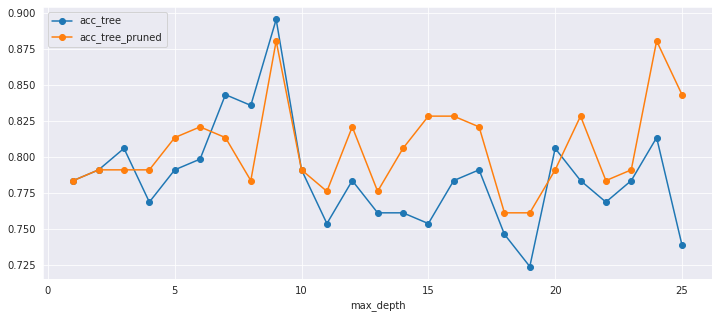

In [ ]:
# Plot
df_metrics.plot(figsize=(12, 5), marker="o")